# Law, Order, and Algorithms
## A statistical approach to assessing _reasonable suspicion_

In [1]:
# Load packages
library(tidyverse)
library(tidymodels)
library(ROCR)

# Set some initial options
options(digits = 3)
theme_set(theme_bw())

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──
✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.8      ✔ rsample   0.0.7 
✔ infer     0.5.3      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.1.2 
✔ parsnip   0.1.2      ✔ yardstick 0.0.7 
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step(

## Background

"Stop-and-frisk" is a police practice of temporarily detaining, questioning, and at times searching civilians on the street for weapons and other contraband.

In New York City, between 2003 and 2013, over 100,000 stops were made per year, with 685,724 stops made in a single year at the height of the practice in 2011. You can read more about this [here](https://en.wikipedia.org/wiki/Stop-and-frisk_in_New_York_City).

The vast majority of those stopped were African-American or Latinx, raising concerns of racial bias. Further, there's concern that many stops were conducted without "reasonable suspicion" of criminal activity, in violation of the Fourth Amendment. 

In this lab, we will work with a sample of stops in NYC made between 2007 and 2013, recorded on a [UF-250 form](https://www.prisonlegalnews.org/news/publications/blank-uf-250-form-stop-question-and-frisk-report-worksheet-nypd-2016/), to explore a statistical approach to assessing potential Fourth Amendment violations outlined in the paper [Precinct or Prejudice? Understanding Racial Disparities in New York City's Stop-and-Frisk Policy](https://5harad.com/papers/stop-and-frisk.pdf) by Goel, Rao, and Shroff.

In [2]:
# Load data
stops <- read_rds("../data/sqf_sample.rds")

# Preprocess the data
cols_to_keep <- c('found_weapon', 'frisked', 'suspected_crime',
                  'precinct',
                  'suspect_race', 'suspect_sex', 'suspect_build',
                  'month', 'day',
                  'stopped_bc_furtive', 'stopped_bc_other', 'stopped_bc_object', 'stopped_bc_drugs', 'stopped_bc_violent', 
                  'stopped_bc_lookout', 'stopped_bc_clothing', 'stopped_bc_casing', 'stopped_bc_bulge', 'stopped_bc_desc',
                  'inside_outside', 'location_housing',
                  'additional_highcrime', 'additional_investigation', 'additional_proximity', 'additional_direction', 'additional_other',
                  'additional_associating', 'additional_sights', 'additional_time', 'additional_evasive', 'additional_report',
                  'radio_run', 'officer_uniform',
                  'suspect_height', 'suspect_weight', 'observation_period', 'suspect_age', 'local_hit_rate', 'year')
stops <- stops %>%
  select(any_of(cols_to_keep)) %>%
  # only keep stops with information in all entries
  na.omit() %>%
  mutate(
    # convert non-numerical variables into factors, grouping values occurring < 0.1% of the time into "Other"
    across(where(is.character) | where(is.logical) | where(is.factor), 
           ~ fct_lump(factor(.x), prop = 0.001)),
    # convert outcome into numeric
    across(all_of('found_weapon'), ~ if_else(.x == "TRUE", 1, 0)),
    frisked = as.logical(frisked),
    # capitalize race/ethnicity groups (but leave 'white' lowercased, following AP convention.)
    suspect_race = if_else(suspect_race == 'white', 'white', str_to_title(suspect_race))
  )

head(stops)

found_weapon,frisked,suspected_crime,precinct,suspect_race,suspect_sex,suspect_build,month,day,stopped_bc_furtive,⋯,additional_evasive,additional_report,radio_run,officer_uniform,suspect_height,suspect_weight,observation_period,suspect_age,local_hit_rate,year
<dbl>,<lgl>,<fct>,<fct>,<chr>,<fct>,<fct>,<ord>,<ord>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>
0,TRUE,cpw,113,Black,male,medium,January,Thursday,TRUE,⋯,FALSE,FALSE,FALSE,FALSE,5.83,180,1,30,0.0229,2011
0,FALSE,criminal possession of marihuana,23,Hispanic,male,medium,August,Friday,TRUE,⋯,FALSE,FALSE,TRUE,TRUE,5.67,170,2,28,0.0929,2011
0,FALSE,criminal possession of marihuana,107,Hispanic,male,medium,May,Tuesday,TRUE,⋯,TRUE,FALSE,FALSE,TRUE,5.83,140,2,17,0.0736,2011
0,TRUE,cpw,44,Black,male,thin,June,Thursday,TRUE,⋯,FALSE,TRUE,FALSE,TRUE,5.50,155,1,23,0.0178,2012
0,TRUE,cpw,115,Hispanic,male,thin,March,Tuesday,FALSE,⋯,TRUE,FALSE,TRUE,TRUE,5.50,170,2,19,0.0222,2009
0,TRUE,cpw,23,Hispanic,male,thin,November,Sunday,FALSE,⋯,TRUE,FALSE,FALSE,TRUE,5.50,165,1,15,0.0443,2009


## The data

This week, we will use the same data frame as last week: `stops`, a sample of stops in NYC, recorded on a 
[UF-250 form][uf250_link].
As a reminder, below is a list of columns in the data, roughly corresponding to the [UF-250 form][uf250_link] (for simplicity, we work with a subset of the available columns):

* Base information regarding stop:
    * `id`, `serial`, `year`, `date`, `day`, `time`, `hour`, `precinct`, `location_housing`, 
      `suspected_crime`, `lat`, `lon`, `xcoord`, `ycoord`

* Circumstances which led to the stop:
    * `stopped_bc_object`, `stopped_bc_desc`, `stopped_bc_casing`, `stopped_bc_lookout`, `stopped_bc_clothing`, `stopped_bc_drugs`, `stopped_bc_furtive`, `stopped_bc_violent`, `stopped_bc_bulge`, `stopped_bc_other`
    
* Suspect demographics:
    * `suspect_dob`, `suspect_id_type`, `suspect_sex`, `suspect_race`,
      `suspect_hispanic`, `suspect_age`, `suspect_height`, `suspect_weight`,
      `suspect_hair`, `suspect_eye`, `suspect_build`, `reason_explained`,
      `others_stopped`

* Whether physical force was used:
    * `force_hands`, `force_wall`, `force_ground`, `force_drawn`,
      `force_pointed`, `force_baton`, `force_handcuffs`,
      `force_pepper`, `force_other`

* Was suspect arrested?: `arrested`
    * if yes: `arrested_reason`

* Was summons issued?: `summons_issued`

* Officer in uniform?: `officer_uniform`, `officer_verbal`, `officer_shield`

* Was person frisked?: `frisked`
    * if yes: `frisked_bc_suspected_crime`, `frisked_bc_weapons`, `frisked_bc_attire`, `frisked_bc_actual_crime`, `frisked_bc_noncompliance`, `frisked_bc_threats`, `frisked_bc_prior`, `frisked_bc_furtive`, `frisked_bc_bulge`

* Was person searched?: `searched`,
    * if yes: `searched_hardobject`, `searched_outline`,
      `searched_admission`, `searched_other`

* Was weapon found?: `found_weapon`
    * if yes: `found_gun`, `found_pistol`, `found_rifle`, `found_assault`,
      `found_knife`, `found_machinegun`, `found_other`
      
* Was other contraband found?: `found_contraband`

* Additional circumstances/factors
    * `additional_report`, `additional_investigation`, `additional_proximity`, 
      `additional_evasive`, `additional_associating`, `additional_direction`, 
      `additional_highcrime`, `additional_time`, `additional_sights`, 
      `additional_other`

* Additional reports prepared: `extra_reports`

* Whether the stop was a result of a radio run: `radio_run`

* Was the stop made inside or outside: `inside_outside`

* Period of observation (minutes): `observation_period`, `stop_length`

* Type of ID the person had (photo, refused, verified, other): `identification`

* Local hit rate: `local_hit_rate`, defined as the average hit rate for drug and CPW stops at the location of the stop for the previous year. Stops closer to the focal point are given more weight than stops farther away, using gaussian kernel averaging. NA if it's other type of stops.

[uf250_link]: https://www.prisonlegalnews.org/media/publications/Blank%20UF-250%20Form%20-%20Stop%2C%20Question%20and%20Frisk%20Report%20Worksheet%2C%20NYPD%2C%202016.pdf
      

## Analysis

For this lab, we will focus on stops for suspicion of criminal possession of a weapon (CPW).

#### Exercise: Data filtering

In [3]:
# Your code here!
# Create a data frame named stops_cpw with only cpw stops as indicated by column suspected_crime
# START solution

stops_cpw <- stops %>%
  filter(suspected_crime == "cpw")

# END solution

One might say that a CPW stop was _ex post_ justified if a weapon was ultimately recovered. To gauge whether such a stop was _ex ante_ justified, we will use the available data to build a risk assessment model, allowing us to estimate the likelihood a stopped individual is carrying a weapon. We can then examine the model-estimated risk scores to see whether people were stopped even though the available evidence suggests that they are unlikely to be carrying a weapon, potentially in violation of the Fourth Amendment. We will look at each of these steps — estimating risk and examining scores — in turn below.

### Estimating risk

For an individual $i$, let $X_i$ be all the information we know about the
individual prior to making the stop decision, and define


$$
Y_i =
\begin{cases}
1 & \textrm{if a weapon is found on individual } i \\
0 & \textrm{otherwise}
\end{cases}
$$


Then, the _risk_ we are interested in measuring can be written as

$$
r_i = \Pr(Y_i = 1 ~|~ X_i).
$$



In other words, we wish to estimate the probability that we will recover a 
weapon from an individual, characterized by covariates $X_i$, if we were to 
stop (and frisk) them.

One way to estimate this probability is to fit a logistic regression on the
subset of individuals who were stopped, to predict whether a weapon will be
found, using all the covariates that an officer observed prior to conducting the
stop. 

Don't worry if you haven't heard of logistic regression before! We'll talk about
it more in later lectures; for now, we'll treat logistic regression as a black-box
that spits out an estimated probability of finding a weapon on someone matching
a certain set of criteria (or _features_) that we specify.

To fit and evaluate our risk model, we split the data into two parts: a _training_ set and a _test_ set.
We fit (or _train_) our logistic regression model using the training set, and then use the fitted model to generate predictions on the test set. This splitting of the data helps to ensure that the model isn't able to "cheat" when making its predictions.

In [4]:
# Split train-test set
stops_train_cpw <- stops_cpw %>%
  filter(year %in% 2009:2010)

stops_test_cpw <- stops_cpw %>%
  filter(year %in% 2011:2012)

We'll start be estimating risk based on whether the officer reported seeing a "bulge" (indicative of carrying a weapon) and whether the officer indicated that the stop occurred in a "high-crime" neighborhood. We train and make predictions with the logistic regression model as follows:

In [5]:
# We start by specifying which risk factors to include in the model
features <- c('stopped_bc_bulge', 'additional_highcrime')

# We will use all covariates listed in `features` to predict the outcome "found_weapon" 
glm_formula <- reformulate(features, response="found_weapon")

# Train model
glm_fit <- glm(glm_formula, data = stops_train_cpw, family = binomial(link = "logit"))

# Make predictions on the test set
predictions <- predict(glm_fit, newdata = stops_test_cpw, type = "response")

At the end of this process, we get a vector of predictions that indicates how likely each person in the test set is to be carrying a weapon, based on the two specified risk factors.

In [6]:
head(predictions)

1      2      3      4      5      6 
0.0356 0.0231 0.0356 0.0231 0.0395 0.0356

To see where these predictions are coming from, we can check how much weight the model is putting on each of the factors, displayed in the `estimate` column in the table below. Based on the historical data, the model believes that people stopped because of a reported "bulge" are at higher risk of carrying a weapon (since the estimate is positive). Further, people stopped because they are in a "high crime" neighborhood are at _lower_ risk of carrying a weapon, compared to those without this factor reported as a basis for the stop (since the estimate is negative).

In [7]:
tidy(glm_fit)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-3.300,0.0293,-112.5,0.00e+00
stopped_bc_bulgeTRUE,0.552,0.0385,14.4,1.00e-46
additional_highcrimeTRUE,-0.444,0.0380,-11.7,1.25e-31


#### Exercise: Model interpretation
Why do you think the "high crime" rationale is associated with _lower_ risk of carrying a weapon in the model above?

Now we'll quantify how well this risk model performs.
There are many ways to evaluate a regression model's performance.
For a binary classification task like the one we are working on (predicting whether or not someone is carrying a weapon), a common performance metric is [AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). Given a random pair of people in the dataset, exactly one of whom is carrying a weapon, the AUC is the probability that the model will correctly identify the person with the weapon. A perfect binary prediction model will thus give an AUC of 1 while a model that is making random guesses will produce an AUC of 0.5.

The code below provides a friendlier interface to the `ROCR` package for computing AUC. (Don't worry about the details of how that code works!)
Given a vector of risk scores and the true answer of whether someone is carrying a weapon, 
the function `compute_auc` returns the AUC of the underlying risk model.

In [8]:
# Helper function to calculate AUC
# Don't worry about the details of how this code works!
compute_auc <- function(probs, labels) {
  pred <- prediction(probs, labels)
  auc <- performance(pred, 'auc')
  auc <- unlist(slot(auc, 'y.values'))
  auc
}

compute_auc(probs = predictions, labels = stops_test_cpw$found_weapon)

[1] 0.606

#### Exercise: Interpreting model fit
Discuss the AUC of the risk model above. How well would you say the model is doing?

#### Exercise: Building a better logistic regression model

In the above model, we used `stopped_bc_bulge` and `additional_highcrime` as the only risk factors used to predict whether an individual has a weapon. Explore incorporating additional factors from the dataset to build a more accurate model. To do this, start with the model-building code above, and then add additional factors to the `features` vector.

In [9]:
# Your code here!
# Build a better logistic regression model here by including more covariates
# START solution

binary_features <- c('precinct',
                     'suspect_build',
                     'month', 'day',
                     'stopped_bc_furtive', 'stopped_bc_other', 'stopped_bc_object', 'stopped_bc_drugs', 'stopped_bc_violent', 
                     'stopped_bc_lookout', 'stopped_bc_clothing', 'stopped_bc_casing', 'stopped_bc_bulge', 'stopped_bc_desc',
                     'inside_outside', 'location_housing',
                     'additional_highcrime', 'additional_investigation', 'additional_proximity', 'additional_direction', 'additional_other',
                     'additional_associating', 'additional_sights', 'additional_time', 'additional_evasive', 'additional_report',
                     'radio_run', 'officer_uniform')
realvalued_features <- c('suspect_height', 'suspect_weight', 'observation_period', 'suspect_age', 'local_hit_rate', 'year')
features <- c(binary_features, realvalued_features)

glm_formula <- reformulate(features, response="found_weapon")
glm_fit <- glm(glm_formula, data = stops_train_cpw, family = binomial(link = "logit"))
predictions <- predict(glm_fit, newdata = stops_test_cpw, type = "response")

# END solution

# check the AUC of the new model
compute_auc(probs = predictions, labels = stops_test_cpw$found_weapon)

[1] 0.819

#### Exercise: Interpreting risk scores

Discuss your risk model. 
Do you think it gives an accurate estimate of the likelihood someone has a weapon, 
based on information observed by the officer?

### Assessing 4A violations

We'll now use our model estimates to assess potential Fourth Amendment violations. To start, we'll compute the fraction of CPW stops that have less than 1% _ex ante_ chance of recovering a weapon.

#### Exercise: Calculate the proportion of low-risk stops

In [10]:
# Add our predictions to the data frame
stops_test_cpw <- stops_test_cpw %>%
  mutate(found_weapon_pred = predictions)

# Given a threshold p between 0 and 1 (e.g., 0.01)
p <- 0.01
# Calculate the proportion of stops with smaller than p ex-ante chance of recovering a weapon

# Your code here!
# START solution
stops_test_cpw %>% 
  summarize(prop_stops = mean(found_weapon_pred < p))
# END solution

prop_stops
<dbl>
0.301


#### Exercise: Interpreting the result

Discuss the result above. Do you think this provides evidence of Fourth Amendment violations?

Above we computed the proportion of stops with less than 1% chance of turning up a weapon. Now we'll repeat this exercise for every threshold (e.g., 0.1% and 2%). 
(This is called the [cumulative distirbution function (CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function) of the risk distribution.)

#### Exercise: Calculate the proportion of stops having less than risk $p$, for different values of $p$

In [11]:
# Your code here!
# create a data frame named risk_dist with 2 columns: p and prop_stops
# representing the proportion of stops having risk less than or equal to p,
# for all values of p.
#
# Hint: start by sorting the stops by risk score, from lowest to highest

# START solution
risk_dist <- stops_test_cpw %>%
  arrange(found_weapon_pred) %>%
  mutate(p = found_weapon_pred,
         prop_stops = 1:n() / n()) %>%
  select(p, prop_stops)
# END solution

We can now plot the proportion of stops less than each risk level. As a point of comparison, we also plot a dashed line showing the overall hit rate in the dataset.

Warning message:
“Removed 2322 row(s) containing missing values (geom_path).”

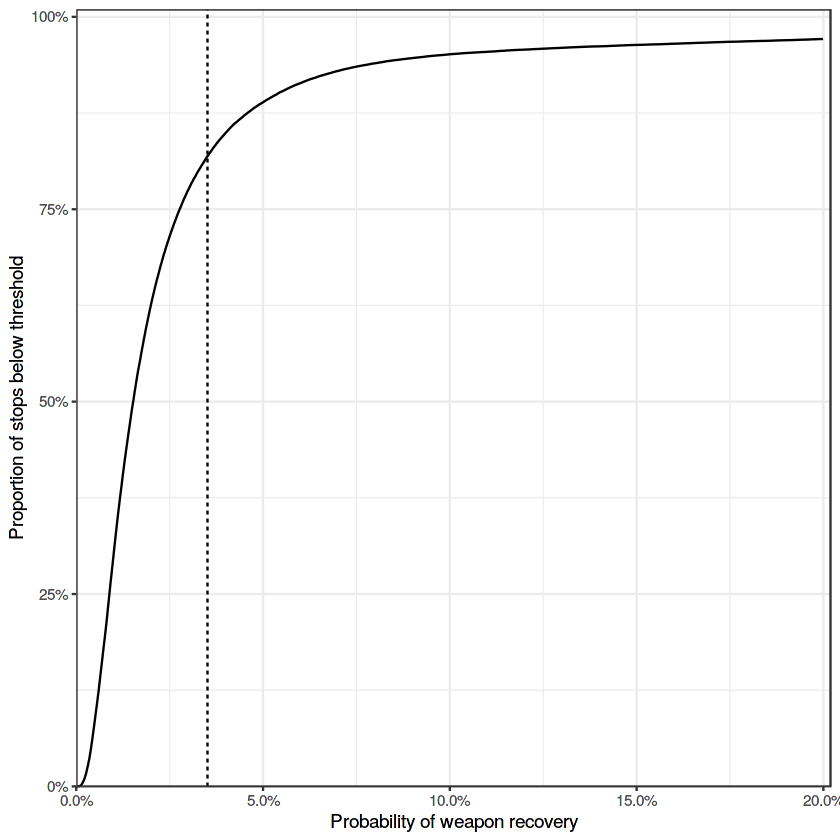

In [12]:
hit_rate_overall <- mean(stops_test_cpw$found_weapon)

ggplot(risk_dist, aes(x = p, y = prop_stops)) +
  geom_vline(xintercept=hit_rate_overall, linetype='dashed') +
  geom_line() +
  scale_x_continuous('Probability of weapon recovery', labels = scales::percent,
                     limits = c(0, 0.2), expand = expansion(mult = c(0, 0.01))) +
  scale_y_continuous('Proportion of stops below threshold', labels = scales::percent,
                     limits = c(0, 1), expand = expansion(mult = c(0, 0.01))) 

#### Exercise: Interpreting the result

Discuss the result above. What do you think the plot above tells us about Fourth Amendment violations?

Now let's generate a version of the plot above disaggregated by race, for those categorized in the dataset as `Black`, `Hispanic`, or `white`.

#### Exercise: Calculate the risk distribution disaggregated by race

In [13]:
# Your code here!
# The output should be a data frame named risk_dist_by_race 
# containing 3 columns: suspect_race, p, and prop_stops
#
# Hint: start by filtering the data to the race groups we consider here; 
# then group and sort the data; finally, compute the proportions

# START solution
risk_dist_by_race <- stops_test_cpw %>%
  filter(suspect_race %in% c("Black", "Hispanic", "white")) %>%
  group_by(suspect_race) %>%
  arrange(found_weapon_pred) %>%
  mutate(p = found_weapon_pred,
         prop_stops = 1:n() / n()) %>%
  select(suspect_race, p, prop_stops)
# END solution

#### Exercise: Hit rate by race

In [14]:
# Your code here!
# For a point of reference in the plot, compute the overall hit rate 
# for Black, Hispanic, and white individuals.
# The output should be a data frame named hit_rate_by_race with 2 columns: suspect_race and hit_rate
# START solution
hit_rate_by_race <- stops_test_cpw %>%
  filter(suspect_race %in% c("Black", "Hispanic", "white")) %>%
  group_by(suspect_race) %>%
  summarize(hit_rate = mean(found_weapon))
# END solution

`summarise()` ungrouping output (override with `.groups` argument)


We now plot the results.

Warning message:
“Removed 2235 row(s) containing missing values (geom_path).”

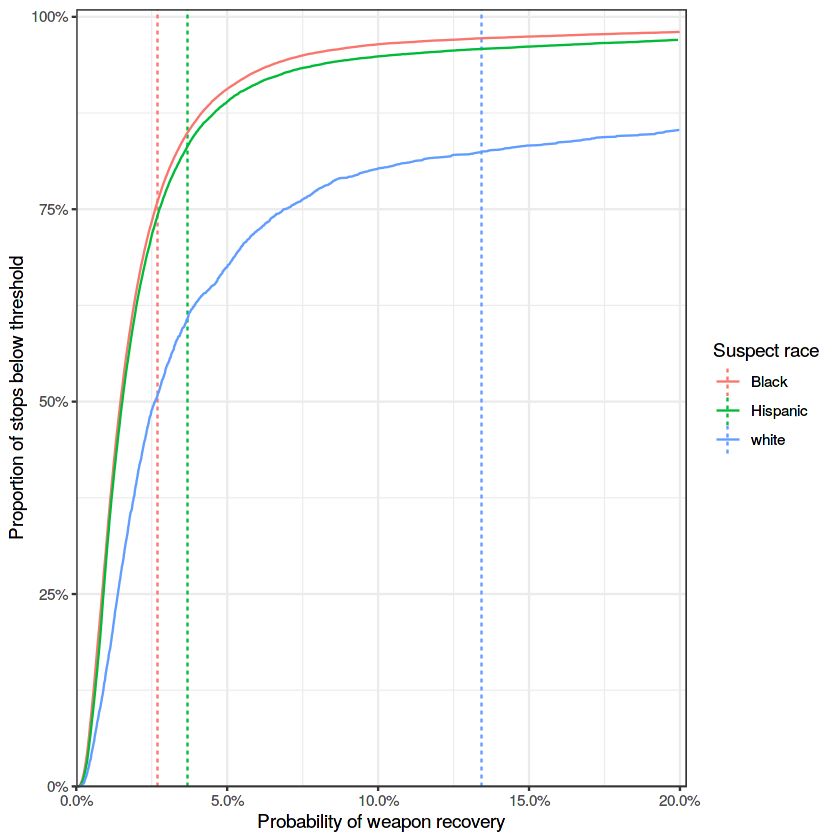

In [15]:
ggplot(risk_dist_by_race, aes(x = p, y = prop_stops, color = suspect_race)) +
  geom_vline(data=hit_rate_by_race, aes(xintercept=hit_rate, color = suspect_race), linetype='dashed') +
  geom_line() +
  scale_x_continuous('Probability of weapon recovery', labels = scales::percent,
                     limits = c(0, .2), expand = expansion(mult = c(0, 0.01))) +
  scale_y_continuous('Proportion of stops below threshold', labels = scales::percent,
                     limits = c(0, 1), expand = expansion(mult = c(0, 0.01))) +
  scale_color_discrete("Suspect race")


#### Exercise: Interpreting the result

Discuss the result above. What do you think the plot above tells us about Fourth Amendment violations? What does it tell us about discrimination?